# Convergence Analysis of the Conditional Gradient Algorithm for the RankSVM

We analyse different step-size algorithms and stopping criteria for the RankSVM and their influence on the convergence. 

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
# --------------------
# Import general stuff
# --------------------
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold

# ----------------------------------
# Import Retention Order SVM classes
# ----------------------------------
from rosvm.ranksvm.rank_svm_cls import KernelRankSVC
from rosvm.ranksvm.analysis_utils import RankSVMAnalyzer
from rosvm.ranksvm.tutorial.utils import read_dataset

## Load Example Data

We work with the five datasets used in the ECCB 2018 publication. Those include retention times measured on different chromatographic systems.

In [7]:
X, y, mol = read_dataset("./ECCB2018_data.csv")
print("Number of Measurements:", len(X))

datasets = y.get_unique_dss()
print("Datasets:", datasets)

Number of Measurements: 1082
Datasets: {'RIKEN', 'LIFE_old', 'FEM_long', 'Eawag_XBridgeC18', 'UFZ_Phenomenex'}


## Separate Data into Training and Test Set

In [8]:
train, test = next(GroupKFold(n_splits=3).split(X, y, groups=mol))
print("(n_train, n_test) = (%d, %d)" % (len(train), len(test)))
assert not (set(mol[train]) & set(mol[test]))

X_train, X_test = X[train], X[test]
y_train, y_test = y[train], y[test]

(n_train, n_test) = (721, 361)


## Train RankSVM Models using different Step-size Calculation

We compare four step-size calculation approaches. Three formulas resulting in a simple diminishing step-size depending on the iteration $k$. The last determines the optimal step-size $\tau^{(k)}$ using line-search.

1) ```diminishing_1```: $$\tau^{(k)}\leftarrow\frac{\tau^{(0)}}{1 + \tau^{(0)} * C * k}$$
2) ```diminishing_2```: $$\tau^{(k)}\leftarrow\tau^{(k-1)} - \frac{\left(\tau^{(k-1)}\right)^2}{2}$$
3) ```diminishing_3```: $$\tau^{(k)}\leftarrow\frac{2}{k + 2}$$
4) ```linesearch```: $$\tau^{(k)}\leftarrow\frac{\mathbf{1}^T(\mathbf{s}-\mathbf{\alpha}^{(k)})-\mathbf{\alpha}^T\mathbf{A}\mathbf{K}\mathbf{A}^T(\mathbf{s}-\mathbf{\alpha}^{(k)})}{(\mathbf{s}-\mathbf{\alpha}^{(k)})^T\mathbf{A}\mathbf{K}\mathbf{A}^T(\mathbf{s}-\mathbf{\alpha}^{(k)})}$$

Here, $\tau^{(0)}$ is the initial step-size, and $k$ is the current iteration (starting with $k=0$), and $C$ is the regularization parameter of the RankSVM.

In [339]:
# Define some of the RankSVM parameters
pair_generation = "random"  
random_state = 9400
C = 1
alpha_threshold = 1e-2
duality_gap_threshold = 5e-3
kernel = "minmax"

# Train multiple RankSVMs
ranksvms = {}
for ss in ["diminishing_1", "diminishing_2", "diminishing_3", "linesearch"]:
    print("Train using:", ss)
    ranksvms[ss] = KernelRankSVC(
        kernel=kernel, pair_generation=pair_generation, random_state=random_state, alpha_threshold=alpha_threshold, debug=True, 
        C=C, step_size=ss, duality_gap_threshold=duality_gap_threshold).fit(X_train, y_train)

Train using: diminishing_1
Train using: diminishing_2
Train using: diminishing_3
Train using: linesearch


### Analyse the RankSVMs

In [133]:
analyzer = RankSVMAnalyzer(ranksvms)  # load RankSVMs into the analyser

#### Step-size Values

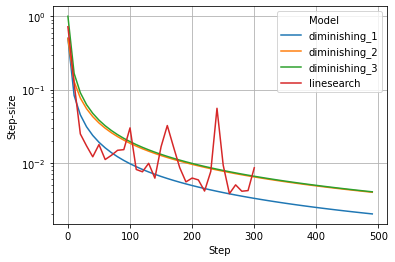

In [136]:
analyzer.plot_step_size(height=2.25, aspect=1.65, sharex=False)

#### Objective Values

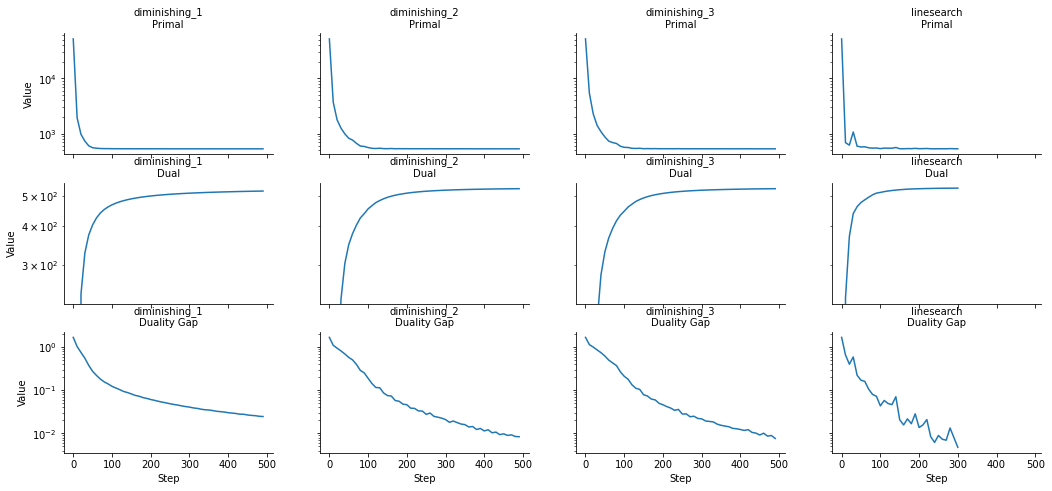

In [134]:
analyzer.plot_objective_functions(height=2.25, aspect=1.65, sharex=True)

The step-size approaches have different convergence, i.e. minimizing the duality gap, speed. The fastest convergence is achieved by the line-search strategy, which reaches the desired duality gap already after 300 iterations. On the other hand ```diminishing_1``` shows the slowest convergence. The duality gap closes very slowly for this approach. The approaches ```diminishing_2``` and ```diminishing_3``` perform very similar with a slower convergence in the beginning, but a better final duality gap.

For our experiments we use a relative duality gap defined as: $$\frac{primal - dual}{|primal| + 1}$$

#### Performance on Training and Validation Set

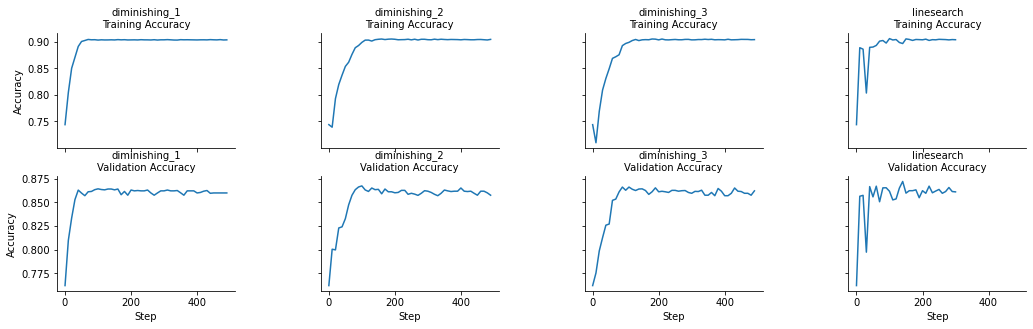

In [135]:
analyzer.plot_accuracies(height=2.25, aspect=1.65, sharex=True)

Interestingly, despite being the step-size approach with the slowest convergence, ```diminishing_1``` reaches the best training set performance (around 0.9) the earliest. The model performance also remains stable on both training and validation set. That we cannot observe any performance change for ```diminishing_1``` could be related ot its fast decay of the step-size (see previous Figure). The line-search appraoch shows a higher variation and the remaining two diminishing strategies show a behavior between ```diminishing_1``` and ```linesearch```.

### Analysis depending on different Parameters

In [ ]:
# Define some of the RankSVM parameters
pair_generation = "random"  
random_state = 9400
alpha_threshold = 1e-2
duality_gap_threshold = 1e-5
kernel = "minmax"
max_iter = 500
tau_0 = 1.0

# Train multiple RankSVMs
ranksvms = {}
for ss in ["diminishing_1", "diminishing_3", "linesearch"]: 
    for C in [2 ** (-2), 2 ** 0, 2 ** 2, 2 ** 4]:
        print("Train using:", (ss, C))
        ranksvms["%s__C=%02.2f" % (ss, C)] = KernelRankSVC(
            kernel=kernel, pair_generation=pair_generation, random_state=random_state, alpha_threshold=alpha_threshold, debug=True, 
            C=C, step_size=ss, duality_gap_threshold=duality_gap_threshold, max_iter=max_iter, tau_0=tau_0).fit(X_train, y_train)

#### C=16, Different Step-size Approaches

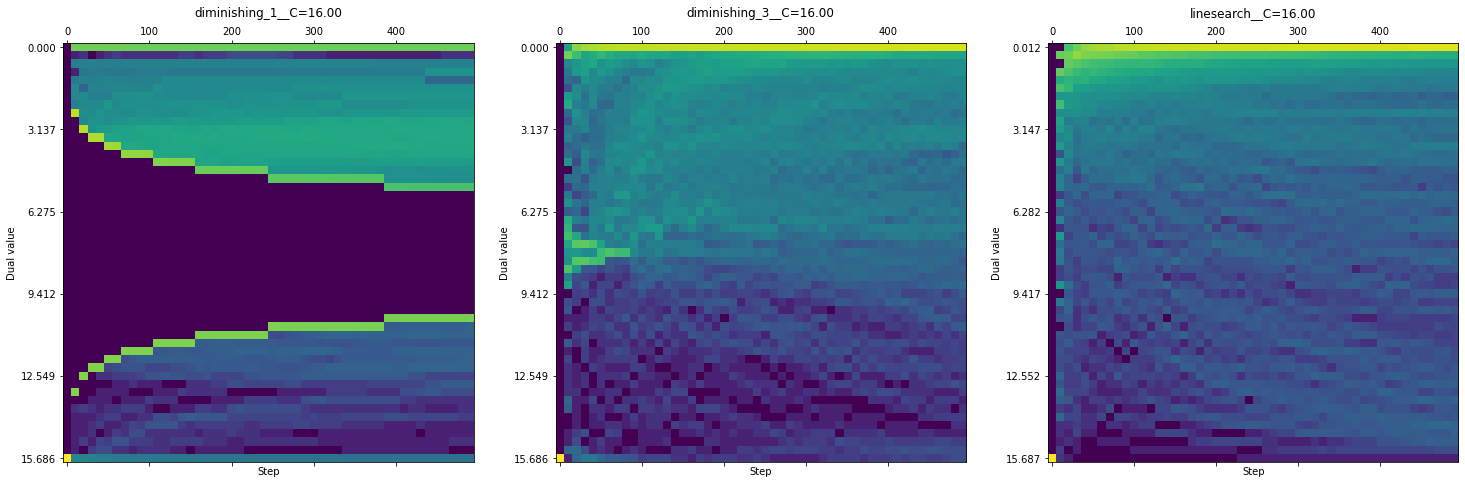

In [355]:
analyzer = RankSVMAnalyzer({k: v for k, v in ranksvms.items() if k.find("__C=16.00") >= 0})  # load RankSVMs into the analyser
analyzer.plot_alphas(zscale="log")

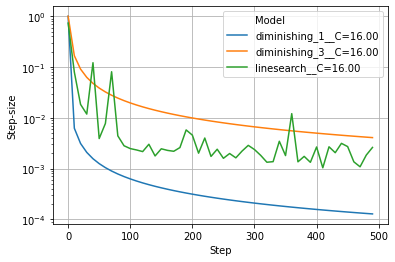

In [356]:
analyzer.plot_step_size()

The step-size using the ```diminishing_1``` strategy leads to the smallest steps. 

                       Training Accuracy        Validation Accuracy       
                                    amax median                amax median
Model                                                                     
diminishing_1__C=16.00              0.85   0.81                0.82   0.80
diminishing_3__C=16.00              0.92   0.90                0.86   0.83
linesearch__C=16.00                 0.92   0.92                0.86   0.85


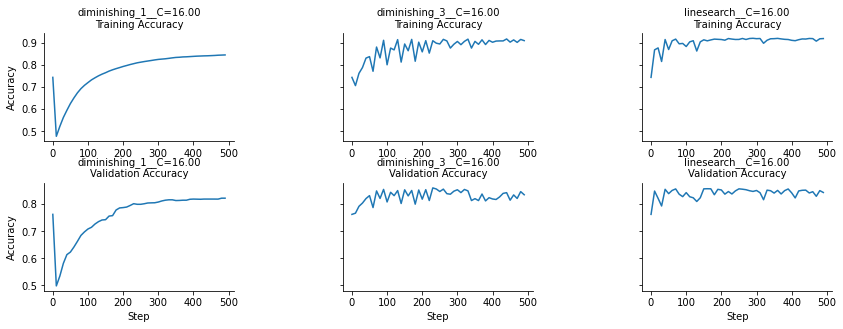

In [353]:
analyzer.plot_accuracies(height=2.25, aspect=1.85, sharex=False)

The performance using the ```diminishing_3``` and ```linesearch``` strategies lead to the best training and validation set results. The line-search leads to a smoother accuracy curve than ```diminishing_3``` step-size. 

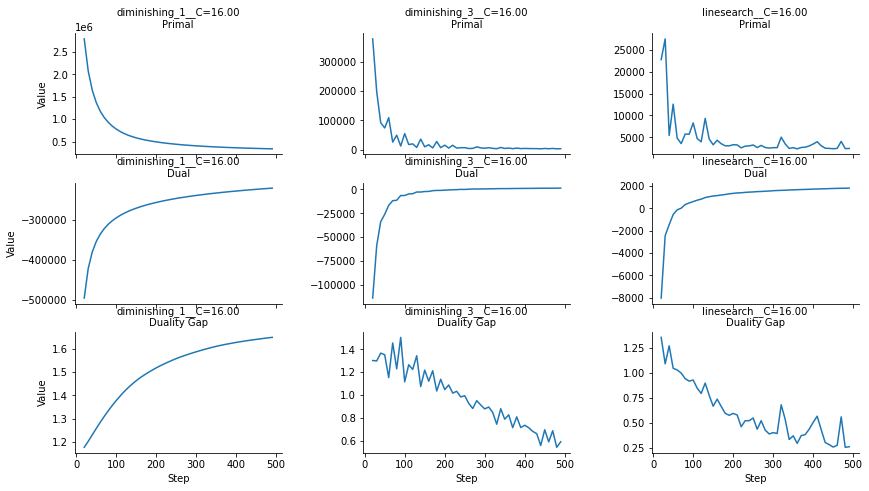

In [359]:
analyzer.plot_objective_functions(height=2.25, aspect=1.85, yscale="linear", skip_measurements=2, sharey=False)

The smallest duality gap can be reached with ```linesearch```. For ```diminishing_1``` it even increases, suggesting that that there is no adequate improvement.

#### C=1, Different Step-size Approaches

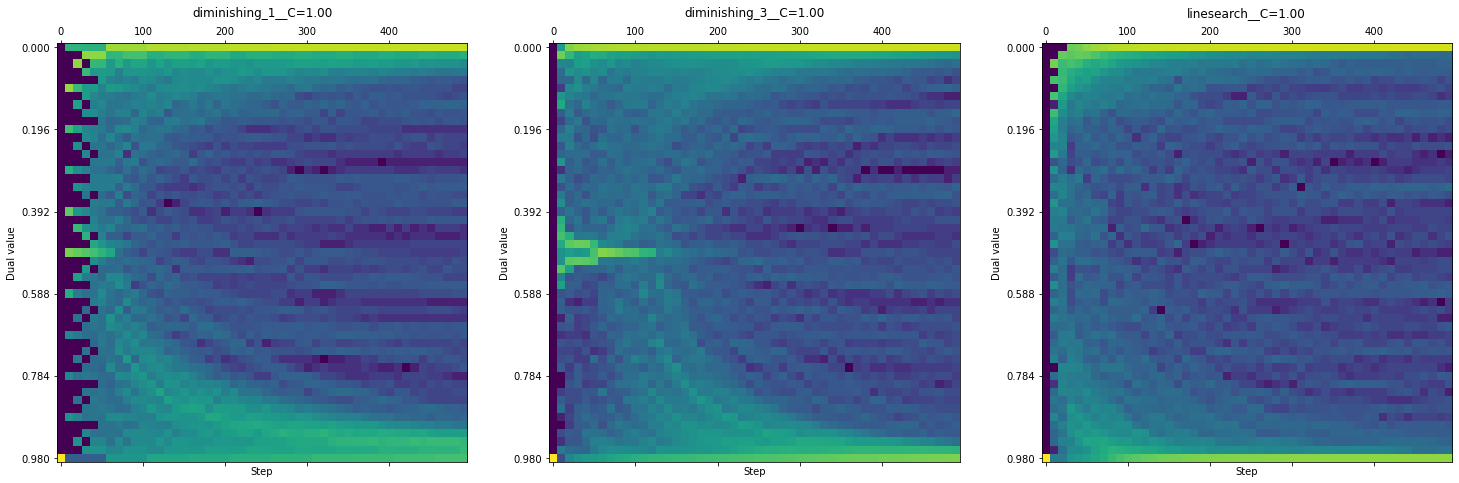

In [368]:
analyzer = RankSVMAnalyzer({k: v for k, v in ranksvms.items() if k.find("__C=1.00") >= 0})  # load RankSVMs into the analyser
analyzer.plot_alphas(zscale="log")

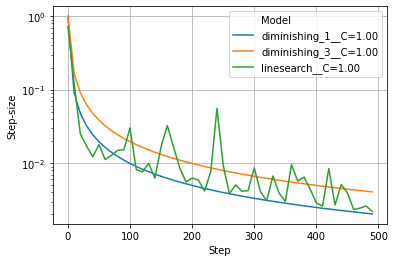

In [369]:
analyzer.plot_step_size()

The step-size using the ```diminishing_1``` strategy leads to the smallest steps. 

                      Training Accuracy        Validation Accuracy       
                                   amax median                amax median
Model                                                                    
diminishing_1__C=0.25              0.88   0.88                0.86   0.85
diminishing_3__C=0.25              0.88   0.88                0.86   0.85
linesearch__C=0.25                 0.88   0.88                0.86   0.85


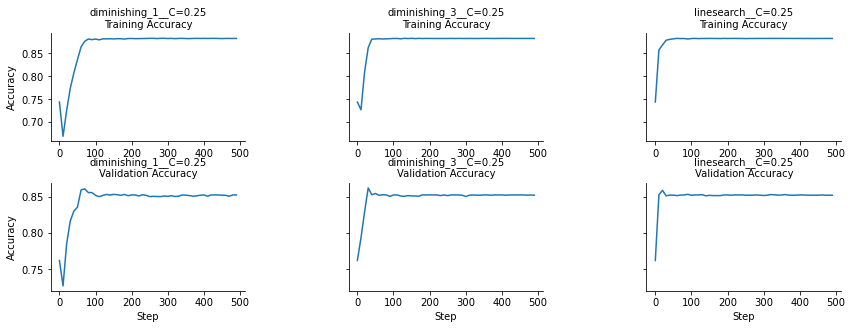

In [366]:
analyzer.plot_accuracies(height=2.25, aspect=1.85, sharex=False)

The performance using the ```diminishing_3``` and ```linesearch``` strategies lead to the best training and validation set results. The line-search leads to a smoother accuracy curve than ```diminishing_3``` step-size. 

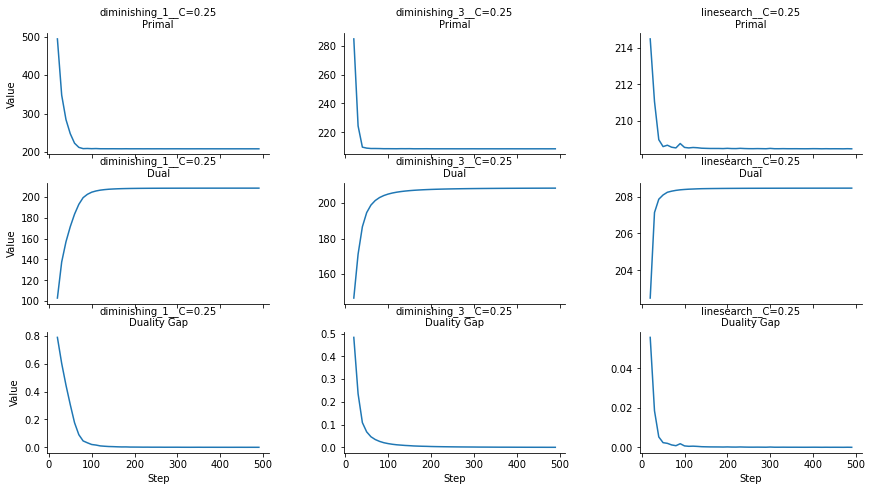

In [367]:
analyzer.plot_objective_functions(height=2.25, aspect=1.85, yscale="linear", skip_measurements=2, sharey=False)

The smallest duality gap can be reached with ```linesearch```. For ```diminishing_1``` it even increases, suggesting that that there is no adequate improvement.